# Sales contract forecast

In [1]:
# download and unzip the data

# warning
import warnings
warnings.filterwarnings('ignore')

# library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib Japanese
import japanize_matplotlib

# functions for displaying data frames
from IPython.display import display

# dislpay option
# numpy floating-point display precision
np.set_printoptions(suppress = True, precision = 4)
# pandas floating-point display precision
pd.options.display.float_format = '{:.4f}'.format
# display all
pd.set_option('display.max_columns', None)
# Default font specification for graphs
plt.rcParams['font.size'] = 14

# Seeds of random numbers
random_seed = 123

In [2]:
# functions for displaying confusion matrices

def make_cm(matrix, columns):
    # matrix numpy array

    # columns list
    n = len(columns)

    # Generate a list of n repetitions of correct data
    act = ['正解データ'] * n
    pred = ['予測結果'] * n

    # dataframe generation
    cm = pd.DataFrame(matrix,
        columns = [pred, columns], index = [act, columns])

    return cm


In [3]:
# download and unzip data
# !wget https://archive.ics.uci.edu/ml/\machine-learning-databases/00222/bank.zip
# !unzip -o bank.zip

# read bank-full.csv
# item delimiter = ; -> sep = ';'
df_all = pd.read_csv('/Users/satoshiido/Documents/Coding_general/Business_AI/data/bank-full.csv', sep = ';')

# rename columns names
columns = [
    '年齢', '職業', '婚姻', '学歴', '債務不履行', '平均残高',
    '住宅ローン', '個人ローン', '連絡手段', '最終通話日',
    '最終通話月', '最終通話秒数', '通話回数_販促中',
    '前回販促後_経過日数', '通話回数_販促前', '前回販促結果',
    '今回販促結果'
]

df_all.columns = columns

# Data Verification

In [4]:
# check dataframe
display(df_all.head())

,年齢,職業,婚姻,学歴,債務不履行,平均残高,住宅ローン,個人ローン,連絡手段,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,前回販促結果,今回販促結果
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
# number of training data and number of columns
print(df_all.shape)
print()

# distribution of the value of "Sales Promotion Result"
print(df_all['今回販促結果'].value_counts())
print()

# "Sales Promotion Result"
rate = df_all['今回販促結果'].value_counts()['yes']/len(df_all)
print(f'営業成功率: {rate:.4f}')

(45211, 17)

no     39922
yes     5289
Name: 今回販促結果, dtype: int64

営業成功率: 0.1170


In [6]:
# 欠損値の確認
print(df_all.isnull().sum())

年齢            0
職業            0
婚姻            0
学歴            0
債務不履行         0
平均残高          0
住宅ローン         0
個人ローン         0
連絡手段          0
最終通話日         0
最終通話月         0
最終通話秒数        0
通話回数_販促中      0
前回販促後_経過日数    0
通話回数_販促前      0
前回販促結果        0
今回販促結果        0
dtype: int64


# Data Preprocessing

In [7]:
# step 1

# One-Hot encoding by using get_dummies function

# One-Hot encoding columns value 
def enc(df, column):
    df_dummy = pd.get_dummies(df[column], prefix = column)
    df = pd.concat([df.drop([column], axis = 1), df_dummy], axis = 1)
    return df

df_all2 = df_all.copy()
df_all2 = enc(df_all2, '職業')
df_all2 = enc(df_all2, '婚姻')
df_all2 = enc(df_all2, '学歴')
df_all2 = enc(df_all2, '連絡手段')
df_all2 = enc(df_all2, '前回販促結果')

display(df_all2.head())

,年齢,債務不履行,平均残高,住宅ローン,個人ローン,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,今回販促結果,職業_admin.,職業_blue-collar,職業_entrepreneur,職業_housemaid,職業_management,職業_retired,職業_self-employed,職業_services,職業_student,職業_technician,職業_unemployed,職業_unknown,婚姻_divorced,婚姻_married,婚姻_single,学歴_primary,学歴_secondary,学歴_tertiary,学歴_unknown,連絡手段_cellular,連絡手段_telephone,連絡手段_unknown,前回販促結果_failure,前回販促結果_other,前回販促結果_success,前回販促結果_unknown
0,58,no,2143,yes,no,5,may,261,1,-1,0,no,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,no,29,yes,no,5,may,151,1,-1,0,no,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,no,2,yes,yes,5,may,76,1,-1,0,no,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,no,1506,yes,no,5,may,92,1,-1,0,no,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,no,1,no,no,5,may,198,1,-1,0,no,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


In [8]:
# step 2

# yes & no -> 1 & 0

# function chnage binary variables to 1 or 0 values
def enc_bin(df, column):
    df[column] = df[column].map(dict(yes = 1, no = 0))
    return df

df_all2 = enc_bin(df_all2, '債務不履行')
df_all2 = enc_bin(df_all2, '住宅ローン')
df_all2 = enc_bin(df_all2, '個人ローン')
df_all2 = enc_bin(df_all2, '今回販促結果')

# display
display(df_all2.head())

,年齢,債務不履行,平均残高,住宅ローン,個人ローン,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,今回販促結果,職業_admin.,職業_blue-collar,職業_entrepreneur,職業_housemaid,職業_management,職業_retired,職業_self-employed,職業_services,職業_student,職業_technician,職業_unemployed,職業_unknown,婚姻_divorced,婚姻_married,婚姻_single,学歴_primary,学歴_secondary,学歴_tertiary,学歴_unknown,連絡手段_cellular,連絡手段_telephone,連絡手段_unknown,前回販促結果_failure,前回販促結果_other,前回販促結果_success,前回販促結果_unknown
0,58,0,2143,1,0,5,may,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,5,may,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,0,2,1,1,5,may,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,0,1506,1,0,5,may,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,0,1,0,0,5,may,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


In [9]:
# step 3

# change month name (jan, feb, ..) to (1, 2, ..)

month_dict = dict(jan = 1, feb = 2, mar = 3, apr = 4, may = 5, 
    jun = 6, jul = 7, aug = 8, sep = 9, oct = 10, nov = 11, dec = 12)

def enc_month(df, column):
    # apply `mont_dict` function to dataframe
    df[column] = df[column].map(month_dict)
    return df

df_all2 = enc_month(df_all2, '最終通話月')

# Data split

In [10]:
# input and labeld data
x = df_all2.drop('今回販促結果', axis = 1)
y = df_all2['今回販促結果'].values

# set the ratio size of training data and evaluation data
test_size = 0.4

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = random_seed, stratify = y)

# Algorithm selection

In [11]:
# list of algorithm options

# logistic regression
from sklearn.linear_model import LogisticRegression
algorithm1 = LogisticRegression(random_state = random_seed)

# decision tree
from sklearn.tree import DecisionTreeClassifier
algorithm2 = DecisionTreeClassifier(random_state = random_seed)

# random_forest
from sklearn.ensemble import RandomForestClassifier
algorithm3 = RandomForestClassifier(random_state = random_seed)

# XGBoost
from xgboost import XGBClassifier
algorithm4 = XGBClassifier(random_state = random_seed)

algorithms = [algorithm1, algorithm2, algorithm3, algorithm4]

In [12]:
# select the best algorithm using the cross-validation method
from sklearn.model_selection import StratifiedKFold
# k = number of data splits = number of verification
stratifiedkfold = StratifiedKFold(n_splits = 3)

from sklearn.model_selection import cross_val_score
for algorithm in algorithms:
    # run cross validation method (scoring = roc curve)
    scores = cross_val_score(algorithm , x_train, y_train, cv = stratifiedkfold, scoring = 'roc_auc')
    score = scores.mean()
    name = algorithm.__class__.__name__
    print(f'平均スコア: {score:.4f} 個別スコア: {score} {name}')

平均スコア: 0.8324 個別スコア: 0.832448046890993 LogisticRegression
平均スコア: 0.6958 個別スコア: 0.6958106807129715 DecisionTreeClassifier
平均スコア: 0.9200 個別スコア: 0.9200266122877183 RandomForestClassifier
[14:58:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:58:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:58:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the ob

## Conclusion

XGBoost is the best option among all three algorithms \
\
-> use XGBoost following analysis

# Learning & prediction & evaluation

In [13]:
# algorithm selection
algorithm = XGBClassifier(random_state = random_seed)

# learning
algorithm.fit(x_train, y_train)

# prediction
y_pred = algorithm.predict(x_test)

[14:58:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [14]:
# evaluation

# confusion matrix
from sklearn.metrics import confusion_matrix
df_matrix = make_cm(confusion_matrix(y_test, y_pred), ['失敗', '成功'])
display(df_matrix)

# precision(適合率), recall(再現率), f-score(F値)
# library
from sklearn.metrics import precision_recall_fscore_support
# average = 'binary' -> the specified model is binary classification model
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average = 'binary')

# results
print(f'適合率: {precision:.4f} 再現率: {recall:.4f} F値: {fscore:.4f}' )

予測結果      
             失敗    成功
正解データ 失敗  15371   598
      成功   1102  1014

適合率: 0.6290 再現率: 0.4792 F値: 0.5440


# Tuning

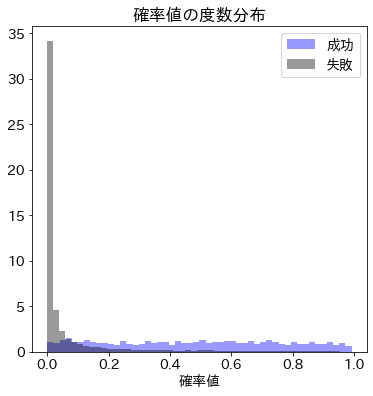

In [15]:
# frequency distribution of probability values
import seaborn as sns

# get probability value of y = 0
y_proba0 = algorithm.predict_proba(x_test)[: ,1]

# data split with y_test = 0, y_test = 1
y0 = y_proba0[y_test == 0]
y1 = y_proba0[y_test == 1]

# scatter plot
plt.figure(figsize = (6, 6))
plt.title('確率値の度数分布')
sns.distplot(y1, kde = False, norm_hist = True, bins = 50, color = 'b', label = '成功')
sns.distplot(y0, kde = False, norm_hist = True, bins = 50, color = 'k', label = '失敗')
plt.xlabel('確率値')
plt.legend()
plt.legend()
plt.show()

## prediction with exept threshold = 0.5

In [16]:
# definition of the prediction function for different threshold values
def pred(algorithm, x, thres):
    # prediction value (matrix)
    y_proba = algorithm.predict_proba(x)

    # prediction value of prediction results = 1
    y_proba1 = y_proba[:,1]
    # prediction value > threshold when prediction results = 1
    y_pred = (y_proba1 > thres).astype(int)
    
    return y_pred

In [17]:
# calculate precision, recall, f-score changing threshold by 0.05
thres_list = np.arange(0.5, 0, -0.05)

for thres in thres_list:
    y_pred  = pred(algorithm, x_test, thres)
    pred_sum = y_pred.sum()
    precision, recall, fscore, _ = precision_recall_fscore_support(
        y_test, y_pred, average = 'binary')
    
    print(f'閾値: {thres:.2f} 陽性(=成功)予測数: {pred_sum}\
        適合率: {precision:.4f} 再現率: {recall:.4f} F値: {fscore:.4f})')

閾値: 0.50 陽性(=成功)予測数: 1612        適合率: 0.6290 再現率: 0.4792 F値: 0.5440)
閾値: 0.45 陽性(=成功)予測数: 1839        適合率: 0.6117 再現率: 0.5317 F値: 0.5689)
閾値: 0.40 陽性(=成功)予測数: 2041        適合率: 0.6022 再現率: 0.5808 F値: 0.5913)
閾値: 0.35 陽性(=成功)予測数: 2304        適合率: 0.5820 再現率: 0.6337 F値: 0.6068)
閾値: 0.30 陽性(=成功)予測数: 2544        適合率: 0.5688 再現率: 0.6838 F値: 0.6210)
閾値: 0.25 陽性(=成功)予測数: 2831        適合率: 0.5440 再現率: 0.7278 F値: 0.6226)
閾値: 0.20 陽性(=成功)予測数: 3184        適合率: 0.5135 再現率: 0.7727 F値: 0.6170)
閾値: 0.15 陽性(=成功)予測数: 3616        適合率: 0.4806 再現率: 0.8214 F値: 0.6064)
閾値: 0.10 陽性(=成功)予測数: 4277        適合率: 0.4361 再現率: 0.8814 F値: 0.5835)
閾値: 0.05 陽性(=成功)予測数: 5519        適合率: 0.3629 再現率: 0.9466 F値: 0.5247)


In [18]:
# maximize fscore by setting threshold = 0.25
y_final = pred(algorithm, x_test, 0.25)

# output confusion_matrix
df_matrix2 = make_cm(confusion_matrix(y_test, y_final), ['失敗', '成功'])
display(df_matrix2)

# precision, recall, fscore
precision, recall, fscore, _ = precision_recall_fscore_support(
    y_test, y_final, average = 'binary')
print(f'適合率: {precision:.4f} 再現率: {recall:.4f} F値: {fscore:.4f}')

予測結果      
             失敗    成功
正解データ 失敗  14678  1291
      成功    576  1540

適合率: 0.5440 再現率: 0.7278 F値: 0.6226


# Importance analysis

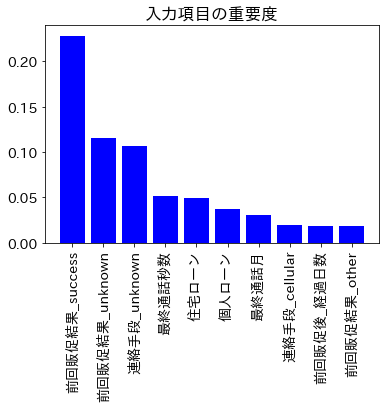

In [19]:
# get vector of importances of each columns
importances = algorithm.feature_importances_

# create series using columns name as key
w = pd.Series(importances, index = x.columns)

# sort the value
u = w.sort_values(ascending = False)

# top 10
v = u[:10]

# show importances of each columns
plt.title('入力項目の重要度')
plt.bar(range(len(v)), v, color = 'b', align = 'center')
plt.xticks(range(len(v)), v.index, rotation = 90)
# we do not know if each columns affect the prediction positively or negatively
plt.show()

## Impcat of each elements on sales_success

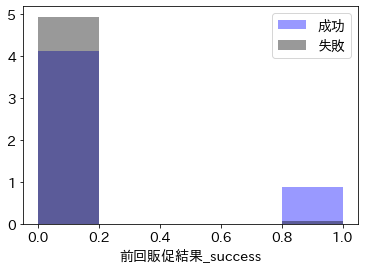

In [20]:
column = '前回販促結果_success'

sns.distplot(x_test[y_test == 1][column], kde = False, norm_hist = True, bins = 5, color = 'b', label = '成功')
sns.distplot(x_test[y_test == 0][column], kde = False, norm_hist = True, bins = 5, color = 'k', label = '失敗')

plt.legend()
plt.show()

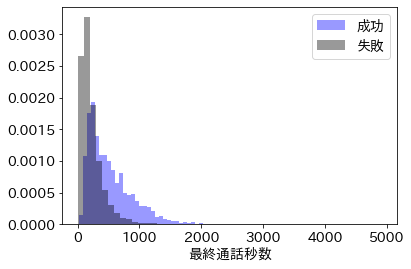

In [21]:
column = '最終通話秒数'

sns.distplot(x_test[y_test == 1][column], kde = False, norm_hist = True, bins = 50, color = 'b', label = '成功')
sns.distplot(x_test[y_test == 0][column], kde = False, norm_hist = True, bins = 50, color = 'k', label = '失敗')

plt.legend()
plt.show()

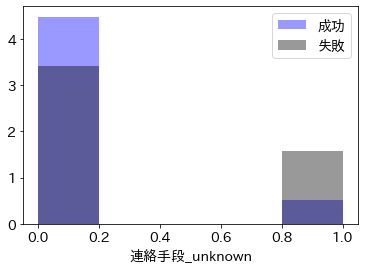

In [22]:
column = '連絡手段_unknown'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True, bins=5, color='b', label='成功')
sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True, bins=5, color='k', label='失敗')

plt.legend()
plt.show()

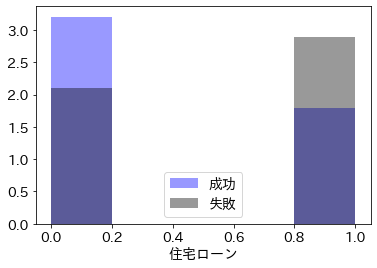

In [23]:
column = '住宅ローン'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True, bins=5, color='b', label='成功')
sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True, bins=5, color='k', label='失敗')

plt.legend()
plt.show()

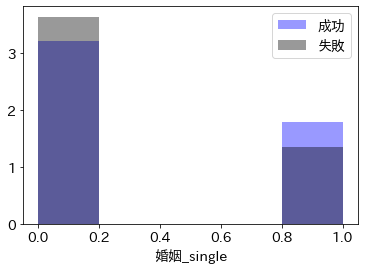

In [24]:
column = '婚姻_single'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True, bins=5, color='b', label='成功')
sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True, bins=5, color='k', label='失敗')

plt.legend()
plt.show()

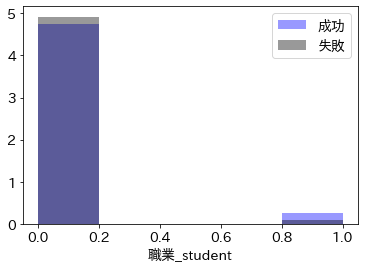

In [25]:
column = '職業_student'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True, bins=5, color='b', label='成功')
sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True, bins=5, color='k', label='失敗')

plt.legend()
plt.show()